In [1]:
import os
import re
import sys
import csv
import time
import json
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from scipy import stats
from scipy import optimize
from scipy.stats import chi2, norm
from scipy.integrate import quad
from scipy.special import erfinv

from sklearn.metrics.pairwise import pairwise_distances

import torch
import falkon

sys.path.insert(0, "../notebooks")
from plot_utils import plot_one_t, plot_two_t


/tmp/ipykernel_1674908/552375591.py:9: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## PARAMETER TUNING ($N_s = 0$)

### TUNING

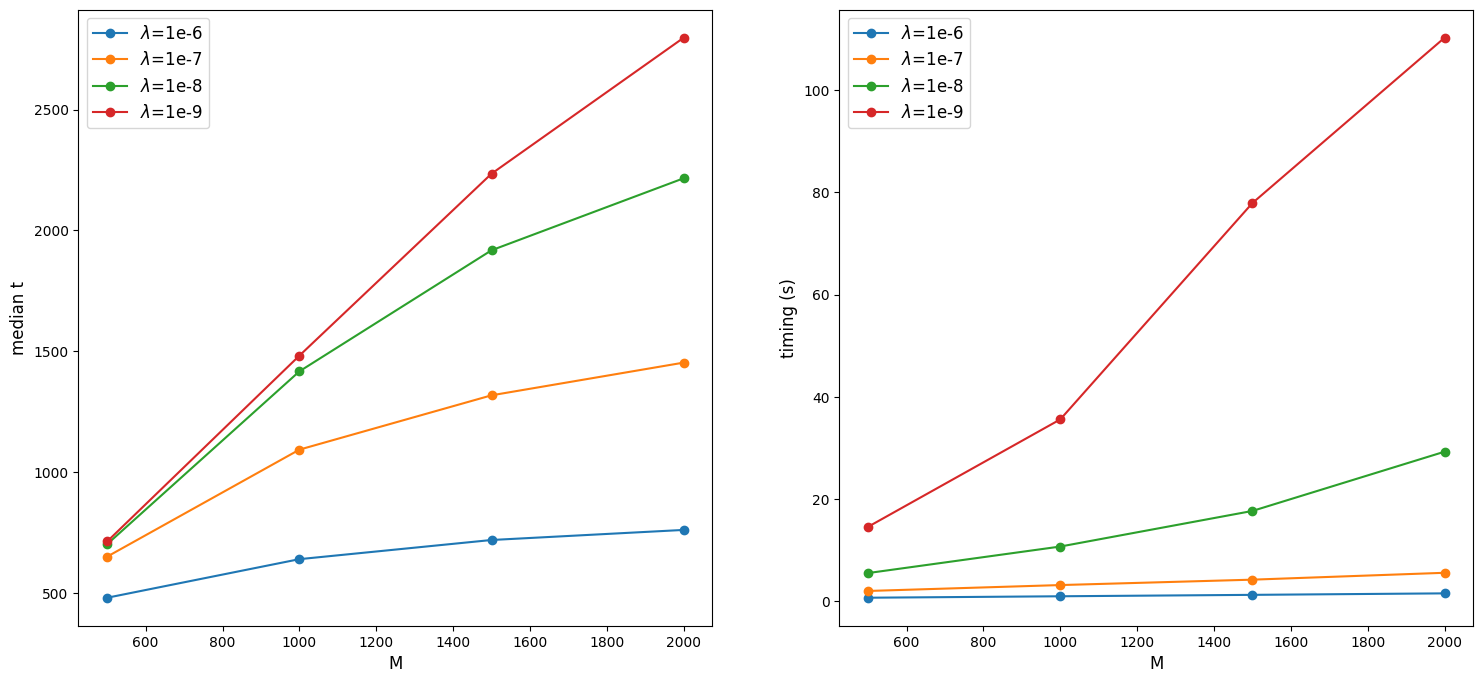

In [2]:
df_m = pd.read_csv("/home/ubuntu/NPLM-Falkon/output/bank_data/results/results.csv", sep="\t")

fig, ax = plt.subplots(figsize=(18,8), nrows=1, ncols=2)
df_m = df_m.sort_values('M', ascending =False)  

ax[0].plot(df_m[df_m['lambda']==1e-6]['M'], df_m[df_m['lambda']==1e-6]['median'], marker='o', markersize=6, label="$\lambda$=1e-6")
ax[0].plot(df_m[df_m['lambda']==1e-7]['M'], df_m[df_m['lambda']==1e-7]['median'], marker='o', markersize=6, label="$\lambda$=1e-7")
ax[0].plot(df_m[df_m['lambda']==1e-8]['M'], df_m[df_m['lambda']==1e-8]['median'], marker='o', markersize=6, label="$\lambda$=1e-8")
ax[0].plot(df_m[df_m['lambda']==1e-9]['M'], df_m[df_m['lambda']==1e-9]['median'], marker='o', markersize=6, label="$\lambda$=1e-9")

# ax[0].errorbar(df_m[df_m['lambda']==1e-6]['M'], df_m[df_m['lambda']==1e-6]['median'], yerr = 1.2533*(df_m[df_m['lambda']==1e-6]['std'])/np.sqrt(config['toys']), ecolor='black', capsize=2)
# ax[0].errorbar(df_m[df_m['lambda']==1e-7]['M'], df_m[df_m['lambda']==1e-7]['median'], yerr = 1.2533*(df_m[df_m['lambda']==1e-7]['std'])/np.sqrt(config['toys']), ecolor='black', capsize=2)
# ax[0].errorbar(df_m[df_m['lambda']==1e-8]['M'], df_m[df_m['lambda']==1e-8]['median'], yerr = 1.2533*(df_m[df_m['lambda']==1e-8]['std'])/np.sqrt(config['toys']), ecolor='black', capsize=2)
# ax[0].errorbar(df_m[df_m['lambda']==1e-9]['M'], df_m[df_m['lambda']==1e-9]['median'], yerr = 1.2533*(df_m[df_m['lambda']==1e-9]['std'])/np.sqrt(config['toys']), ecolor='black', capsize=2)

ax[0].set_xlabel('M', fontsize=12)
ax[0].set_ylabel('median t', fontsize=12)
ax[0].legend(fontsize =12)

ax[1].plot(df_m[df_m['lambda']==1e-6]['M'], df_m[df_m['lambda']==1e-6]['timing'], marker='o', markersize=6, label="$\lambda$=1e-6")
ax[1].plot(df_m[df_m['lambda']==1e-7]['M'], df_m[df_m['lambda']==1e-7]['timing'], marker='o', markersize=6, label="$\lambda$=1e-7")
ax[1].plot(df_m[df_m['lambda']==1e-8]['M'], df_m[df_m['lambda']==1e-8]['timing'], marker='o', markersize=6, label="$\lambda$=1e-8")
ax[1].plot(df_m[df_m['lambda']==1e-9]['M'], df_m[df_m['lambda']==1e-9]['timing'], marker='o', markersize=6, label="$\lambda$=1e-9")

ax[1].set_xlabel('M', fontsize=12)
ax[1].set_ylabel('timing (s)', fontsize=12)
ax[1].legend(fontsize =12)

# plt.savefig('/home/ubuntu/NPLM-Falkon/plot/bank/median_t_vs_M.png', format='png', dpi=300, facecolor="white")

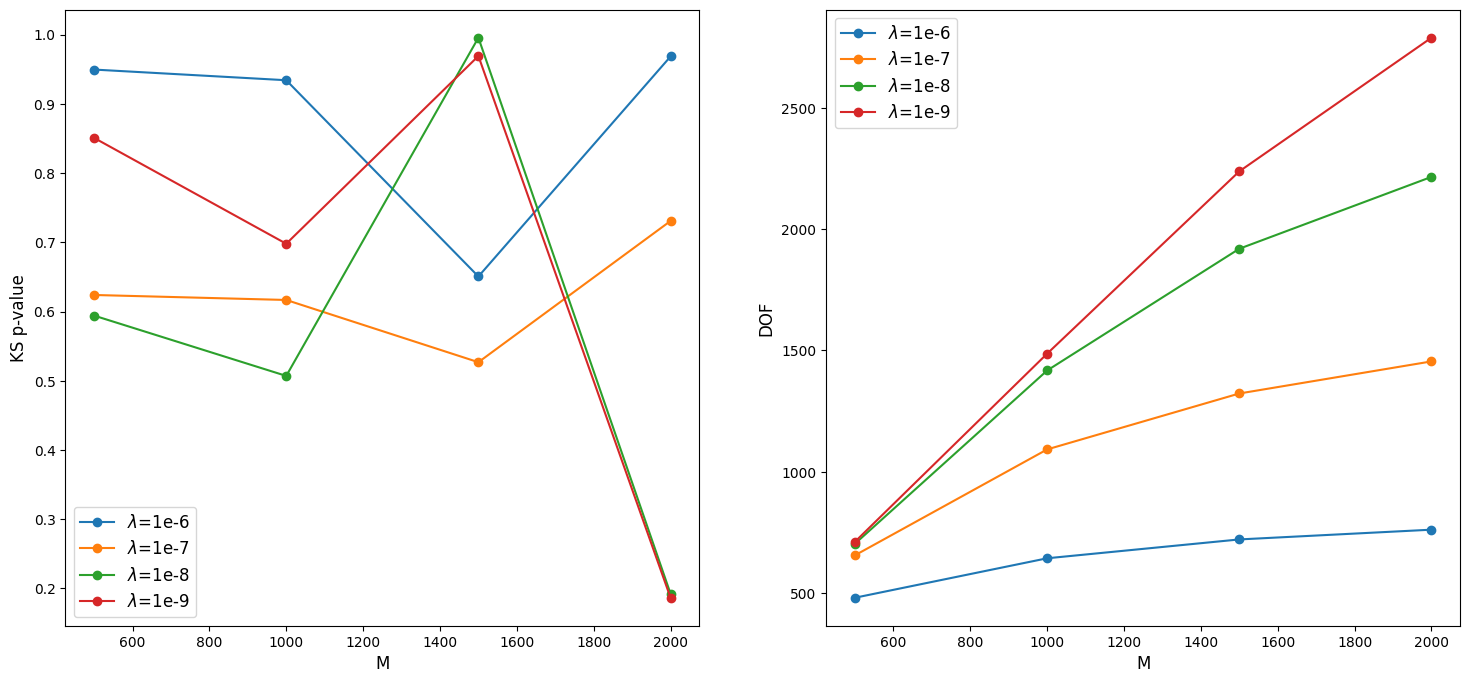

In [3]:
df_m = pd.read_csv("/home/ubuntu/NPLM-Falkon/output/bank_data/results/results.csv", sep="\t")

fig, ax = plt.subplots(figsize=(18,8), nrows=1, ncols=2)
df_m = df_m.sort_values('M', ascending =False)  

ax[0].plot(df_m[df_m['lambda']==1e-6]['M'], df_m[df_m['lambda']==1e-6]['p_value'], marker='o', markersize=6, label="$\lambda$=1e-6")
ax[0].plot(df_m[df_m['lambda']==1e-7]['M'], df_m[df_m['lambda']==1e-7]['p_value'], marker='o', markersize=6, label="$\lambda$=1e-7")
ax[0].plot(df_m[df_m['lambda']==1e-8]['M'], df_m[df_m['lambda']==1e-8]['p_value'], marker='o', markersize=6, label="$\lambda$=1e-8")
ax[0].plot(df_m[df_m['lambda']==1e-9]['M'], df_m[df_m['lambda']==1e-9]['p_value'], marker='o', markersize=6, label="$\lambda$=1e-9")

ax[0].set_xlabel('M', fontsize=12)
ax[0].set_ylabel('KS p-value', fontsize=12)
ax[0].legend(fontsize=12)

ax[1].plot(df_m[df_m['lambda']==1e-6]['M'], df_m[df_m['lambda']==1e-6]['dof'], marker='o', markersize=6, label="$\lambda$=1e-6")
ax[1].plot(df_m[df_m['lambda']==1e-7]['M'], df_m[df_m['lambda']==1e-7]['dof'], marker='o', markersize=6, label="$\lambda$=1e-7")
ax[1].plot(df_m[df_m['lambda']==1e-8]['M'], df_m[df_m['lambda']==1e-8]['dof'], marker='o', markersize=6, label="$\lambda$=1e-8")
ax[1].plot(df_m[df_m['lambda']==1e-9]['M'], df_m[df_m['lambda']==1e-9]['dof'], marker='o', markersize=6, label="$\lambda$=1e-9")

ax[1].set_xlabel('M', fontsize=12)
ax[1].set_ylabel('DOF', fontsize=12)
ax[1].legend(fontsize =12)

# plt.savefig('/home/ubuntu/NPLM-Falkon/plot/bank/p_value_vs_M.png', format='png', dpi=300, facecolor="white")


### BEST t distribution 

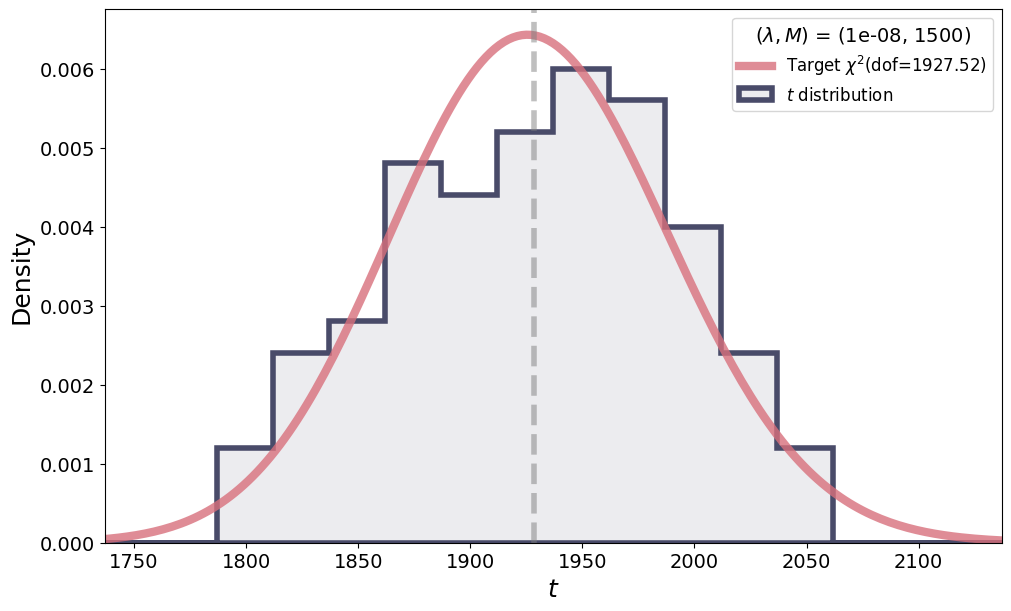

In [10]:
l=1e-8;     M=1500
with open('../output/bank_data/2024_2_23_8-20/ttest_time_'+str(l)+'_'+str(M)+'.csv') as f:
    t_ref_final = np.array([float(row.split()[0]) for row in f])

df_fit, loc, scale = chi2.fit(t_ref_final, floc=0, fscale=1)
t_ref_bins  = np.arange(int(np.min(t_ref_final))-50, int(np.max(t_ref_final))+100, 25)
xgrid_ref   = np.arange(int(np.min(t_ref_final))-100, int(np.max(t_ref_final))+100, 2)

ref_chi2 = chi2(df=df_fit)

plot_one_t(
    t_distribution  = t_ref_final,
    t_bins          = t_ref_bins,
    chi2            = ref_chi2,
    chi2_grid       = xgrid_ref,
    show_hist       = True,
    show_error      = False,
    compute_rate    = False,
    err_marker      = "o",
    err_markersize  = 10,
    err_capsize     = 5,
    err_elinewidth  = 4,
    err_capthick    = 4,
    err_color       = "black",
    figsize         = (10, 6),
    fontsize        = 18,
    cms             = False,
    cms_label       = "",
    cms_rlabel      = "",
    hist_ecolor     = ("#494B69", 1.0),
    hist_fcolor     = ("#494B69", 0.1),
    chi2_color      = ("#D8707C", 0.8),
    hist_lw         = 4,
    chi2_lw         = 6,
    hist_type       = "stepfilled",
    hist_label      = "$\it{t}$ distribution",
    chi2_label      = "Target $\chi^2$(dof=%.2f)"%(df_fit),
    xlabel          = r"$t$",
    ylabel          = "Density",
    show_plot       = True,
    save_plot       = False,
    plot_name       = "t_distribution_"+str(l)+"_"+str(M),
    plot_path       = "",
    plot_format     = "png",
    return_fig      = False,
    plot_params     = True,
    hyperparams     = str(l)+", "+str(M),

)

In [11]:
_, ks_p_value = stats.kstest(t_ref_final, "chi2", args=(df_fit,))
ks_p_value

0.6159338126384011

In [9]:
len(t_ref_final)

210

# SIGNAL $\neq$ 0

## SHAPE and RENORMALIZATION


In [70]:
dir = '2024_2_28_11_6_sig_100'
path = '/home/ubuntu/NPLM-Falkon/output/bank_data/'+dir+'/'
json_path = path+dir+'.json'
with open(json_path) as f:
    config = json.load(f)
config

{'OUTPUT_PATH': '/home/ubuntu/NPLM-Falkon/output/bank_data/',
 'DATA_PATH': '/home/ubuntu/NPLM-Falkon/data/creditcard.csv',
 'PLOT_PATH': '/home/ubuntu/NPLM-Falkon/plot/bank/',
 'toys': 100,
 'N_REF': 3000,
 'N_BKG': 1000,
 'N_SIG': 100,
 'M_list': [1500],
 'l_list': [1e-08],
 'sigma': 9.528979837939284,
 'shape_only': False}

#### Plot the two t distribution

In [71]:
with open(path + '/ttest_time_'+str(l)+'_'+str(M)+'.csv') as f:
    t_data_final = np.array([float(row.split()[0]) for row in f])


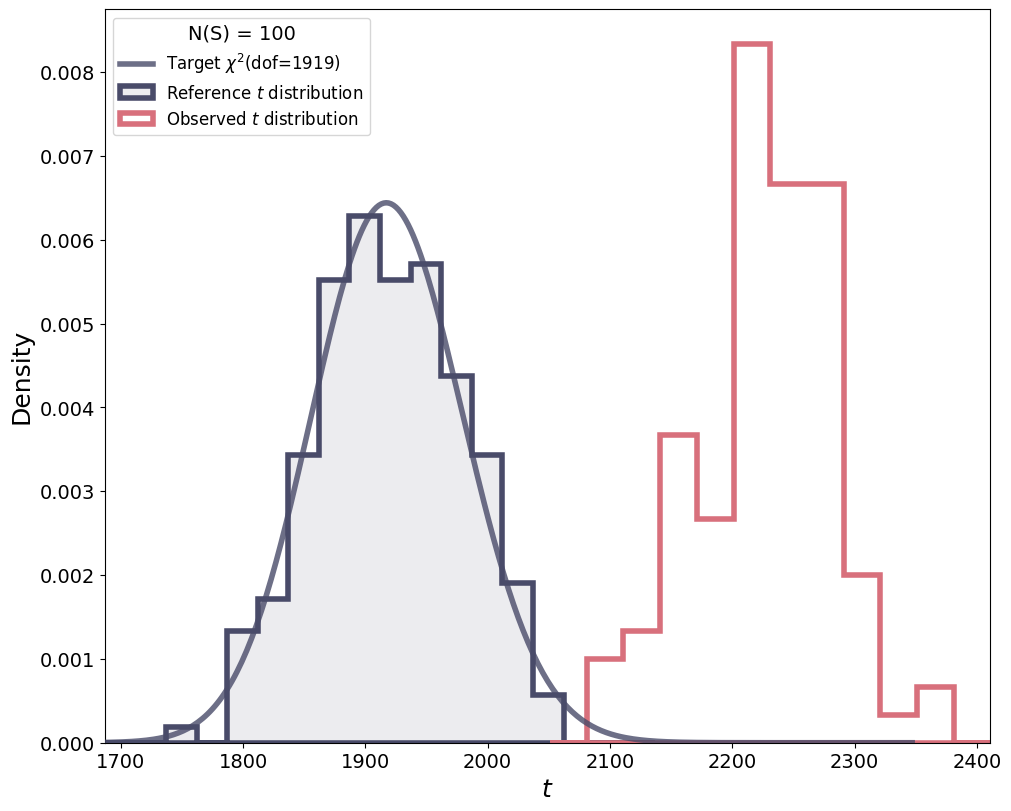

In [76]:
t_data_bins = np.arange(int(np.min(t_data_final))-50, int(np.max(t_data_final))+50, 30)
xgrid_data  = np.arange(int(np.min(t_data_final))-50, int(np.max(t_data_final))+50, 2)
t_ref_bins  = np.arange(int(np.min(t_ref_final))-50, int(np.max(t_ref_final))+100, 25)
xgrid_ref   = np.arange(int(np.min(t_ref_final))-100, int(np.max(t_ref_final))+300, 2)

plot_two_t(
    t_distribution_1  = np.array(t_ref_final),
    t_bins_1          = t_ref_bins,
    t_distribution_2  = np.array(t_data_final),
    t_bins_2          = t_data_bins,
    chi2              = ref_chi2,
    chi2_grid         = xgrid_ref,
    show_error_1      = False,
    show_error_2      = False,
    show_hist_1       = True,
    show_hist_2       = True,
    compute_rate_1    = False,
    compute_rate_2    = False,
    err_marker_1      = "o",
    err_marker_2      = "o",
    err_markersize_1  = 10,
    err_markersize_2  = 10,
    err_capsize_1     = 5,
    err_capsize_2     = 5,
    err_elinewidth_1  = 4,
    err_elinewidth_2  = 4,
    err_capthick_1    = 4,
    err_capthick_2    = 4,
    figsize           = (10, 8),
    fontsize          = 18,
    cms               = False,
    cms_label         = "",
    cms_rlabel        = "",
    hist_ecolor_1     = ("#494B69", 1),
    hist_ecolor_2     = ("#D8707C", 1),
    hist_fcolor_1     = ("#494B69", 0.1),
    hist_fcolor_2     = ("#D8707C", 0),
    err_ecolor_1      = ("#494B69", 1),
    err_ecolor_2      = ("#D8707C", 1),
    chi2_color        = ("#494B69", 0.8),
    hist_lw_1         = 4,
    hist_lw_2         = 4,
    chi2_lw           = 4,
    hist_type_1       = "stepfilled",
    hist_type_2       = "stepfilled",
    hist_label_1      = "Reference $\it{t}$ distribution",
    hist_label_2      = "Observed $\it{t}$ distribution",
    chi2_label        = "Target $\chi^2$(dof=%i)"%(df_fit),
    xlabel            = "$\it{t}$",
    ylabel            = "Density",
    show_plot         = True,
    save_plot         = False,
    plot_name         = "t_distribution_signal",
    plot_path         = "/home/ubuntu/NPLM-Falkon/output/bank_data/results/results.csv",
    plot_format       = "png",
    return_fig        = False,
    plot_params       = True,
    hyperparams       = str(l)+", "+str(M),
    N_SIG             = config['N_SIG']  
)

In [77]:
t_obs = np.median(t_data_final)
p_val = 1 - ref_chi2.cdf(t_obs)
print(1-chi2.cdf(np.median(t_data_final), df_fit))
Z_obs     = norm.ppf(chi2.cdf(np.median(t_data_final), df_fit))
t_obs_err = 1.2533*np.std(t_data_final)*1./np.sqrt(config['toys'])
Z_obs_p   = norm.ppf(chi2.cdf(np.median(t_data_final)+t_obs_err, df_fit))
Z_obs_m   = norm.ppf(chi2.cdf(np.median(t_data_final)-t_obs_err, df_fit))

print('Z = %s (+%s/-%s)'%(str(np.around(Z_obs, 2)), str(np.around(Z_obs_p-Z_obs, 2)), str(np.around(Z_obs-Z_obs_m, 2))))

8.355353846578595e-07
Z = 4.79 (+0.1/-0.1)


### Overall performances

In [78]:
def extract_Nsig(file:str):
    N_SIG = int(file[file.rfind('_sig_') + len('_sig_'):] ) 
    return N_SIG

In [196]:
df_s = pd.DataFrame(columns=['N_sig', 'p_value', 'Z_obs','Z_obs_m', 'Z_obs_p', 'timing'])
folders = [config['OUTPUT_PATH']+directory for directory in os.listdir(config['OUTPUT_PATH']) if 'sig' in directory and '_SOn' not in directory]
for dir in folders:
    N_sig = extract_Nsig(dir)
    with open(dir + '/ttest_time_'+str(l)+'_'+str(M)+'.csv') as f:
        t_data = np.array([float(row.split()[0]) for row in f])
    with open(dir + '/ttest_time_'+str(l)+'_'+str(M)+'.csv') as f:
        t_timing = np.array([float(row.split()[1]) for row in f])

    '''ordinare e tirare fuori il numero di signal events e printare solo lo Z score'''
    t_obs = np.median(t_data)
    p_val = 1 - chi2.cdf(np.median(t_data), df_fit)
    Z_obs     = norm.ppf(chi2.cdf(np.median(t_data), df_fit))
    t_obs_err = 1.2533*np.std(t_data)*1./np.sqrt(len(t_data))
    Z_obs_p   = norm.ppf(chi2.cdf(np.median(t_data)+t_obs_err, df_fit))
    Z_obs_m   = norm.ppf(chi2.cdf(np.median(t_data)-t_obs_err, df_fit))
    
    df_s = pd.concat([pd.DataFrame([[N_sig, p_val, Z_obs, Z_obs-Z_obs_m, Z_obs_p-Z_obs, np.mean(t_timing)]], columns=df_s.columns), df_s], ignore_index=True)

df_s = df_s.sort_values('N_sig', ascending =True)
df_s['p_value']     = df_s['p_value'].round(5)


pd.options.display.float_format = '{:,.4f}'.format
df_s


/tmp/ipykernel_28812/534373101.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_s = pd.concat([pd.DataFrame([[N_sig, p_val, Z_obs, Z_obs-Z_obs_m, Z_obs_p-Z_obs, np.mean(t_timing)]], columns=df_s.columns), df_s], ignore_index=True)


,N_sig,p_value,Z_obs,Z_obs_m,Z_obs_p,timing
1,10,0.3599,0.3587,0.1146,0.1144,4.7488
4,20,0.1568,1.0077,0.1067,0.1065,4.6862
5,30,0.0626,1.5329,0.1158,0.1155,4.8511
0,40,0.0214,2.0255,0.0966,0.0964,4.6419
3,50,0.0088,2.3739,0.1136,0.1133,4.7516
2,80,0.0001,3.6480,0.1152,0.1149,4.8675
6,100,0.0000,4.7896,0.1012,0.1010,4.8512


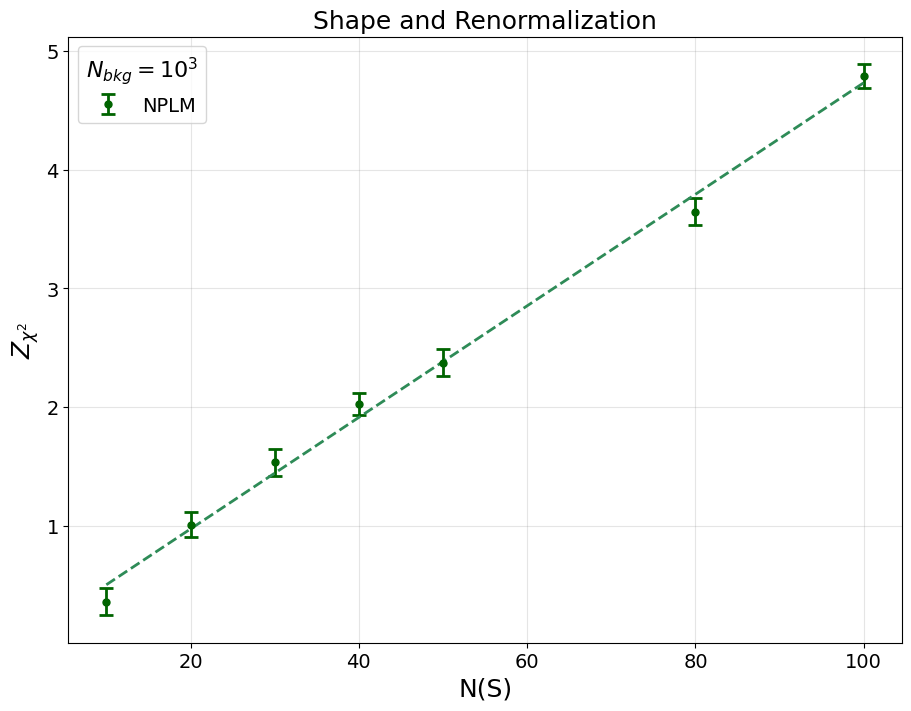

In [201]:
par ,_ =optimize.curve_fit(lambda x,m,q: m*x+q, df_s['N_sig'], df_s['Z_obs'])
m,q = par[0], par[1]

fig, ax = plt.subplots(figsize=(9,7), constrained_layout=True)
ax.set_title('Shape and Renormalization',fontsize = 18)
ax.tick_params(axis = "x", labelsize = 14, which = "major")
ax.tick_params(axis = "y", labelsize = 14, which = "major")
ax.set_xlabel('N(S)', fontsize = 18)
ax.set_ylabel('$Z_{\chi^2}$', fontsize = 18)
ax.errorbar(df_s['N_sig'], df_s['Z_obs'], yerr=np.array((df_s['Z_obs_m'], df_s['Z_obs_p']), ndmin=2),
            label='NPLM',
            marker='o', lw=2, ls='', color='darkgreen',elinewidth=2, capsize=5, markersize=5, capthick=2)
ax.plot(df_s['N_sig'], m*df_s['N_sig']+q, lw=2, linestyle='--', color='seagreen')
ax.grid(color='grey', alpha=0.2, which='major')
ax.legend(fontsize=14, title='$N_{bkg}=10^3$', title_fontsize=16)

## SHAPE-ONLY EFFECT

In [ ]:
json_path = '/home/ubuntu/NPLM-Falkon/output/bank_data/2024_2_28_10_17_sig_10/2024_2_28_10_17_sig_10.json'
with open(json_path) as f:
    config = json.load(f)
    
config

{'OUTPUT_PATH': '/home/ubuntu/NPLM-Falkon/output/bank_data/',
 'DATA_PATH': '/home/ubuntu/NPLM-Falkon/data/creditcard.csv',
 'PLOT_PATH': '/home/ubuntu/NPLM-Falkon/plot/bank/',
 'toys': 100,
 'N_REF': 3000,
 'N_BKG': 1000,
 'N_SIG': 10,
 'M_list': [1500],
 'l_list': [1e-08],
 'sigma': 9.601215794671894,
 'shape_only': False}

In [191]:
def extract_Nsig_SO(file:str):
    matches = re.search(r'_sig_(\d+)_SOn', file)
    return int(matches.group(1))

In [192]:
df_so = pd.DataFrame(columns=['N_sig', 'p_value', 'Z_obs','Z_obs_m', 'Z_obs_p', 'timing'])
folders = [config['OUTPUT_PATH']+directory for directory in os.listdir(config['OUTPUT_PATH']) if 'sig' in directory and '_SOn' in directory]
for dir in folders:
    N_sig = extract_Nsig_SO(dir)
    with open(dir + '/ttest_time_'+str(l)+'_'+str(M)+'.csv') as f:
        t_data = np.array([float(row.split()[0]) for row in f])
    with open(dir + '/ttest_time_'+str(l)+'_'+str(M)+'.csv') as f:
        t_timing = np.array([float(row.split()[1]) for row in f])

    '''ordinare e tirare fuori il numero di signal events e printare solo lo Z score'''
    t_obs = np.median(t_data)
    p_val = 1 - chi2.cdf(np.median(t_data), df_fit)
    Z_obs     = norm.ppf(chi2.cdf(np.median(t_data), df_fit))
    t_obs_err = 1.2533*np.std(t_data)*1./np.sqrt(len(t_data))
    Z_obs_p   = norm.ppf(chi2.cdf(np.median(t_data)+t_obs_err, df_fit))
    Z_obs_m   = norm.ppf(chi2.cdf(np.median(t_data)-t_obs_err, df_fit))
    
    df_so = pd.concat([pd.DataFrame([[N_sig, p_val, Z_obs, Z_obs-Z_obs_m, Z_obs_p-Z_obs, np.mean(t_timing)]], columns=df_so.columns), df_so], ignore_index=True)

df_so = df_so.sort_values('N_sig', ascending =True)
df_so['p_value']     = df_so['p_value'].round(5)


pd.options.display.float_format = '{:,.4f}'.format
df_so


/tmp/ipykernel_28812/3759780404.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_so = pd.concat([pd.DataFrame([[N_sig, p_val, Z_obs, Z_obs-Z_obs_m, Z_obs_p-Z_obs, np.mean(t_timing)]], columns=df_so.columns), df_so], ignore_index=True)


,N_sig,p_value,Z_obs,Z_obs_m,Z_obs_p,timing
3,10,0.2987,0.5281,0.1069,0.1066,5.0411
0,20,0.2048,0.8247,0.1241,0.1238,4.9368
4,30,0.1294,1.1293,0.1142,0.1140,5.2358
1,40,0.0561,1.5887,0.1283,0.1279,5.2030
5,50,0.0392,1.7602,0.1101,0.1099,5.0790
2,80,0.0019,2.8963,0.1121,0.1118,5.3106
6,100,0.0001,3.7401,0.1136,0.1134,4.6495


### Overall performances

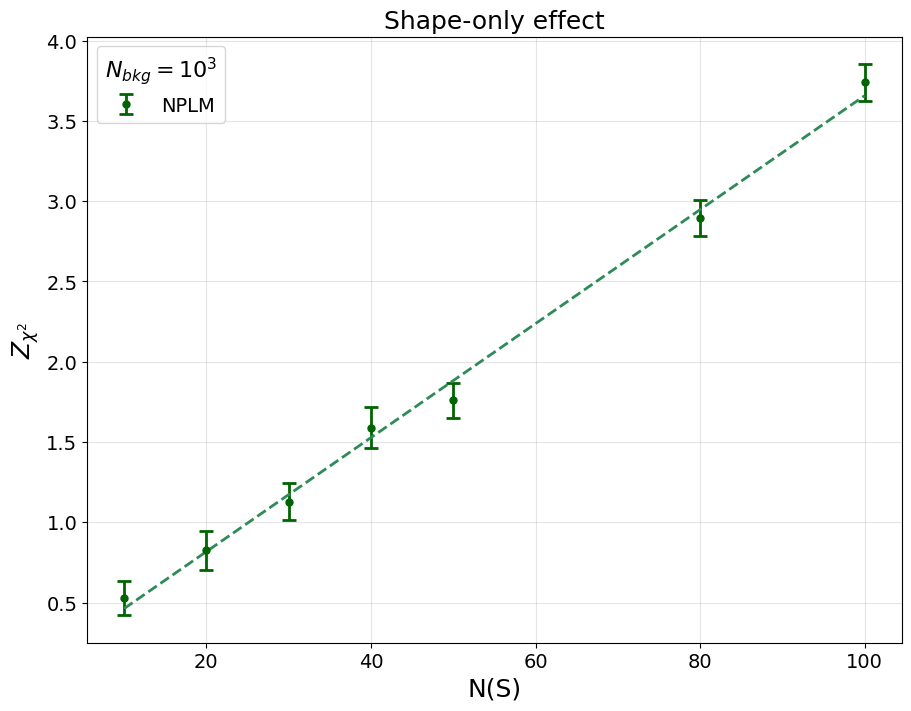

In [200]:
par ,_ =optimize.curve_fit(lambda x,m,q: m*x+q, df_so['N_sig'], df_so['Z_obs'])
m,q = par[0], par[1]

fig, ax = plt.subplots(figsize=(9,7), constrained_layout=True)
ax.set_title('Shape-only effect', fontsize=18)
ax.tick_params(axis = "x", labelsize = 14, which = "major")
ax.tick_params(axis = "y", labelsize = 14, which = "major")
ax.set_xlabel('N(S)', fontsize = 18)
ax.set_ylabel('$Z_{\chi^2}$', fontsize = 18)
ax.errorbar(df_so['N_sig'], df_so['Z_obs'], yerr=np.array((df_so['Z_obs_m'], df_so['Z_obs_p']), ndmin=2),
            label='NPLM',
            marker='o', lw=2, ls='', color='darkgreen',elinewidth=2, capsize=5, markersize=5, capthick=2)
ax.plot(df_so['N_sig'], m*df_so['N_sig']+q, lw=2, linestyle='--', color='seagreen')
ax.grid(color='grey', alpha=0.2, which='major')
ax.legend(fontsize=14, title='$N_{bkg}=10^3$', title_fontsize=16)

# $N_0$ study

## test params

In [21]:
# path = "/home/ubuntu/NPLM-Falkon/output/bank_data/2024_2_23_8-20/ttest_time_1e-08_1500.csv"
# path="/home/ubuntu/NPLM-Falkon/output/bank_data/test_params/2024_2_29_10_8_ref_3000_bkg_1000_sig_0/ttest_time_1e-08_1000.csv"
# path="/home/ubuntu/NPLM-Falkon/output/bank_data/signal/2024_2_29_13_36_ref_3000_bkg_1000_sig_0/ttest_time_1e-08_1500.csv"
path="../output/bank_data/test_params/2024_2_29_14_34_ref_5000_bkg_1000_sig_0/ttest_time_1e-08_1000.csv"

with open(path) as f:
    t_list = np.array([float(row.split()[0]) for row in f])

dof_fit, _, _ = chi2.fit(t_list, floc=0, fscale=1)
_, ks_p_value = stats.kstest(t_list, "chi2", args=(dof_fit,))
ks_p_value


0.939300066534642

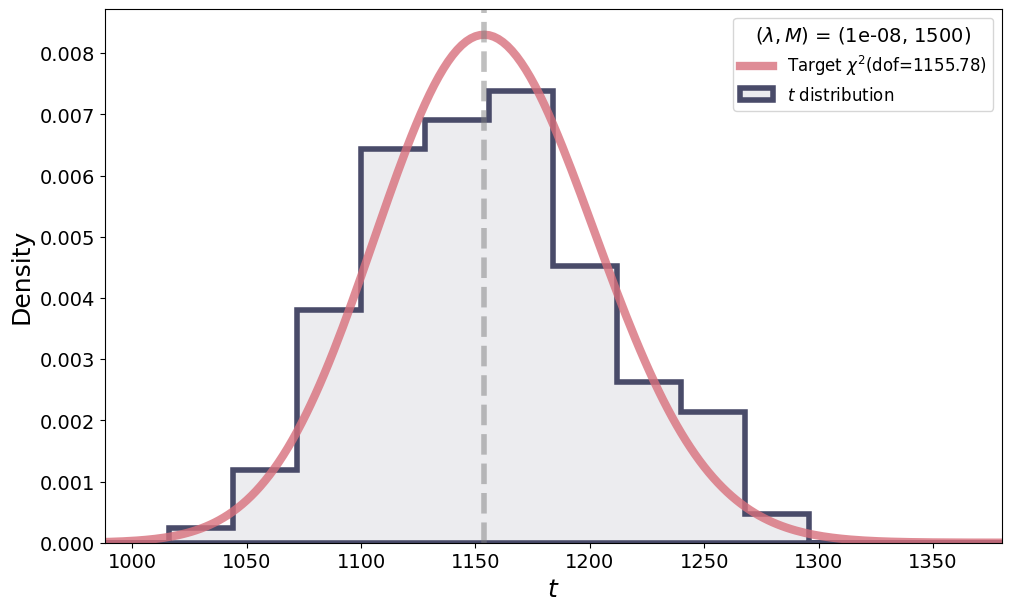

In [132]:
ref_chi2 = chi2(df=dof_fit)
t_ref_bins  = np.arange(int(np.min(t_list))-50, int(np.max(t_list))+100, 28)
xgrid_ref   = np.arange(int(np.min(t_list))-100, int(np.max(t_list))+100, 2)
plot_one_t(
    t_distribution  = t_list,
    t_bins          = t_ref_bins,
    chi2            = ref_chi2,
    chi2_grid       = xgrid_ref,
    show_hist       = True,
    show_error      = False,
    compute_rate    = False,
    err_marker      = "o",
    err_markersize  = 10,
    err_capsize     = 5,
    err_elinewidth  = 4,
    err_capthick    = 4,
    err_color       = "black",
    figsize         = (10, 6),
    fontsize        = 18,
    cms             = False,
    cms_label       = "",
    cms_rlabel      = "",
    hist_ecolor     = ("#494B69", 1.0),
    hist_fcolor     = ("#494B69", 0.1),
    chi2_color      = ("#D8707C", 0.8),
    hist_lw         = 4,
    chi2_lw         = 6,
    hist_type       = "stepfilled",
    hist_label      = "$\it{t}$ distribution",
    chi2_label      = "Target $\chi^2$(dof=%.2f)"%(dof_fit),
    xlabel          = r"$t$",
    ylabel          = "Density",
    show_plot       = True,
    save_plot       = False,
    plot_name       = "t_distribution_"+str(l)+"_"+str(M),
    plot_path       = "",
    plot_format     = "png",
    return_fig      = False,
    plot_params     = True,
    hyperparams     = str(l)+", "+str(M),

)

In [17]:
def path_to_Z(path_ref:str, path_sig):

    with open(path_ref) as f1:
        t_ref_final = np.array([float(row.split()[0]) for row in f1])
    with open(path_sig) as f:
        t_data_final = np.array([float(row.split()[0]) for row in f])

    dof_fit, _, _ = chi2.fit(t_ref_final, floc=0, fscale=1)
    _, ks_p_value = stats.kstest(t_ref_final, "chi2", args=(dof_fit,))
    print("KS - p value:\t",np.around(ks_p_value,3))
    
    t_obs = np.median(t_data_final)
    # p_val = 1 - ref_chi2.cdf(t_obs)
    print("p_value obs:\t", np.around(1-chi2.cdf(np.median(t_data_final), dof_fit),3))
    Z_obs     = norm.ppf(chi2.cdf(np.median(t_data_final), dof_fit))
    t_obs_err = 1.2533*np.std(t_data_final)*1./150
    Z_obs_p   = norm.ppf(chi2.cdf(np.median(t_data_final)+t_obs_err, dof_fit))
    Z_obs_m   = norm.ppf(chi2.cdf(np.median(t_data_final)-t_obs_err, dof_fit))

    print('Z = %s (+%s/-%s)\n'%(str(np.around(Z_obs, 3)), str(np.around(Z_obs_p-Z_obs, 2)), str(np.around(Z_obs-Z_obs_m, 2))))
    

In [18]:
print("5k, 1.2k, 1e-6, 1k")
path_ref1 = '../output/bank_data/test_params/2024_2_29_14_26_ref_5000_bkg_1200_sig_0/ttest_time_1e-06_1000.csv'
# path_sig1 = "../output/bank_data/test_params/2024_2_29_15_22_ref_5000_bkg_1200_sig_24/ttest_time_1e-06_1000.csv"
path_sig1 = "../output/bank_data/test_params/2024_2_29_15_46_ref_5000_bkg_1200_sig_36/ttest_time_1e-06_1000.csv"
path_to_Z(path_ref1, path_sig1)

print("5k, 1k, 1e-8, 1k")
path_ref2 = "../output/bank_data/test_params/2024_2_29_14_34_ref_5000_bkg_1000_sig_0/ttest_time_1e-08_1000.csv"
# path_sig2 = "../output/bank_data/test_params/2024_2_29_15_13_ref_5000_bkg_1000_sig_20/ttest_time_1e-08_1000.csv"
path_sig2 = "../output/bank_data/test_params/2024_2_29_15_47_ref_5000_bkg_1000_sig_30/ttest_time_1e-08_1000.csv"
path_to_Z(path_ref2, path_sig2)

print("3k, 1k, 1e-8, 1.5k")
path_ref3 = "../output/bank_data/test_params/2024_2_29_13_36_ref_3000_bkg_1000_sig_0/ttest_time_1e-08_1500.csv"
# path_sig3 = "../output/bank_data/signal/2024_2_28_10_25_sig_20/ttest_time_1e-08_1500.csv"
path_sig3 = "../output/bank_data/test_params/2024_2_29_15_47_ref_3000_bkg_1000_sig_30/ttest_time_1e-08_1500.csv"
path_to_Z(path_ref3, path_sig3)



5k, 1.2k, 1e-6, 1k
KS - p value:	 0.93
p_value obs:	 0.008
Z = 2.428 (+0.01/-0.01)

5k, 1k, 1e-8, 1k
KS - p value:	 0.939
p_value obs:	 0.083
Z = 1.383 (+0.01/-0.01)

3k, 1k, 1e-8, 1.5k
KS - p value:	 0.915
p_value obs:	 0.084
Z = 1.381 (+0.01/-0.01)



### NEW MODEL TESTING
$N_0 = 5000$, N(0)=1200, $\lambda$ = 1e-6, M=1000,

0.9298966354942554


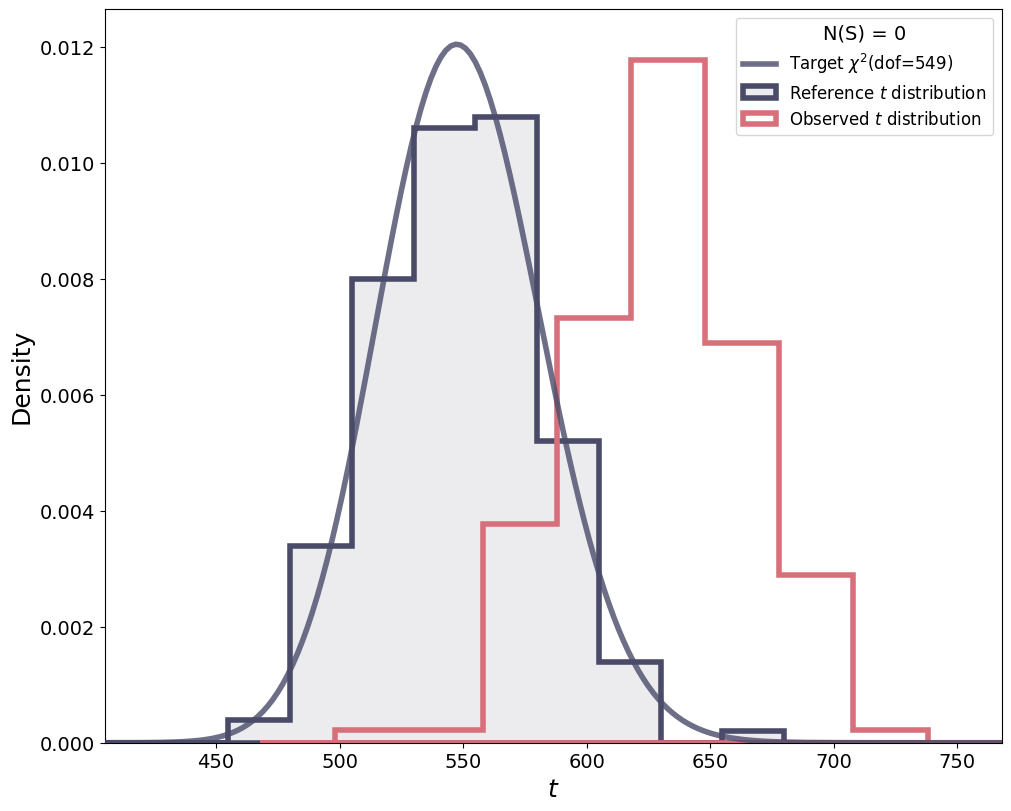

In [184]:
# path_sig ='../output/bank_data/signal/2024_2_29_12_4_ref_5000_bkg_1200_sig_10/ttest_time_1e-06_1000.csv'
path_sig ="../output/bank_data/test_params/2024_2_29_15_22_ref_5000_bkg_1200_sig_24/ttest_time_1e-06_1000.csv"
# path_ref ='../output/bank_data/N_study/2024_2_29_8_47_ref_5000_bkg_1200_sig_0/ttest_time_1e-06_1000.csv'
path_ref ='../output/bank_data/test_params/2024_2_29_14_26_ref_5000_bkg_1200_sig_0/ttest_time_1e-06_1000.csv'

with open(path_ref) as f1:
    t_ref_final = np.array([float(row.split()[0]) for row in f1])
with open(path_sig1) as f:
    t_data_final = np.array([float(row.split()[0]) for row in f])

dof_fit, _, _ = chi2.fit(t_ref_final, floc=0, fscale=1)
_, ks_p_value = stats.kstest(t_ref_final, "chi2", args=(dof_fit,))
print(ks_p_value)

t_data_bins = np.arange(int(np.min(t_data_final))-50, int(np.max(t_data_final))+50, 30)
xgrid_data  = np.arange(int(np.min(t_data_final))-50, int(np.max(t_data_final))+50, 2)
t_ref_bins  = np.arange(int(np.min(t_ref_final))-50, int(np.max(t_ref_final))+100, 25)
xgrid_ref   = np.arange(int(np.min(t_ref_final))-100, int(np.max(t_ref_final))+300, 2)
ref_chi2 = chi2(df=dof_fit)

plot_two_t(
    t_distribution_1  = np.array(t_ref_final),
    t_bins_1          = t_ref_bins,
    t_distribution_2  = np.array(t_data_final),
    t_bins_2          = t_data_bins,
    chi2              = ref_chi2,
    chi2_grid         = xgrid_ref,
    show_error_1      = False,
    show_error_2      = False,
    show_hist_1       = True,
    show_hist_2       = True,
    compute_rate_1    = False,
    compute_rate_2    = False,
    err_marker_1      = "o",
    err_marker_2      = "o",
    err_markersize_1  = 10,
    err_markersize_2  = 10,
    err_capsize_1     = 5,
    err_capsize_2     = 5,
    err_elinewidth_1  = 4,
    err_elinewidth_2  = 4,
    err_capthick_1    = 4,
    err_capthick_2    = 4,
    figsize           = (10, 8),
    fontsize          = 18,
    cms               = False,
    cms_label         = "",
    cms_rlabel        = "",
    hist_ecolor_1     = ("#494B69", 1),
    hist_ecolor_2     = ("#D8707C", 1),
    hist_fcolor_1     = ("#494B69", 0.1),
    hist_fcolor_2     = ("#D8707C", 0),
    err_ecolor_1      = ("#494B69", 1),
    err_ecolor_2      = ("#D8707C", 1),
    chi2_color        = ("#494B69", 0.8),
    hist_lw_1         = 4,
    hist_lw_2         = 4,
    chi2_lw           = 4,
    hist_type_1       = "stepfilled",
    hist_type_2       = "stepfilled",
    hist_label_1      = "Reference $\it{t}$ distribution",
    hist_label_2      = "Observed $\it{t}$ distribution",
    chi2_label        = "Target $\chi^2$(dof=%i)"%(dof_fit),
    xlabel            = "$\it{t}$",
    ylabel            = "Density",
    show_plot         = True,
    save_plot         = False,
    plot_name         = "t_distribution_signal",
    plot_path         = "/home/ubuntu/NPLM-Falkon/output/bank_data/results/results.csv",
    plot_format       = "png",
    return_fig        = False,
    plot_params       = True,
    hyperparams       = str(l)+", "+str(M),
    N_SIG             = config['N_SIG']  
)

In [185]:
t_obs = np.median(t_data_final)
p_val = 1 - ref_chi2.cdf(t_obs)
print(1-chi2.cdf(np.median(t_data_final), dof_fit))
Z_obs     = norm.ppf(chi2.cdf(np.median(t_data_final), dof_fit))
t_obs_err = 1.2533*np.std(t_data_final)*1./np.sqrt(config['toys'])
Z_obs_p   = norm.ppf(chi2.cdf(np.median(t_data_final)+t_obs_err, dof_fit))
Z_obs_m   = norm.ppf(chi2.cdf(np.median(t_data_final)-t_obs_err, dof_fit))

print('Z = %s (+%s/-%s)'%(str(np.around(Z_obs, 2)), str(np.around(Z_obs_p-Z_obs, 2)), str(np.around(Z_obs-Z_obs_m, 2))))

0.007583998196343367
Z = 2.43 (+0.12/-0.12)
